In [1]:
%matplotlib inline

import os
import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

from scipy.signal import resample, butter, lfilter
from scipy.io.wavfile import read as wav_read
from scipy.fftpack import fft

from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedKFold

In [2]:
# dict_signals = {}
# dict_labels = {}

# pwd = 'ibs_true/'
# files = os.listdir(pwd)
# for f in files:
#     w = wav_read(pwd + f)[1]
#     if len(w) < 20000:
#         # filter some short signals
#         continue
#     people = int(f.split('_')[0])
#     if people not in dict_signals:
#         dict_signals[people] = []
#     dict_signals[people].append(w)
#     dict_labels[people] = 1
    
# pwd = 'ibs_false/'
# files = os.listdir(pwd)
# for f in files:
#     w = wav_read(pwd + f)[1]
#     if len(w) < 20000:
#         # filter some short signals
#         continue
#     people = int(f.split('_')[0])
#     if people not in dict_signals:
#         dict_signals[people] = []
#     dict_signals[people].append(w)
#     dict_labels[people] = 0
    
# signals = [dict_signals[x] for x in dict_signals.keys()]
# labels = [dict_labels[x] for x in dict_signals.keys()]

In [3]:
people = []
signals = []
labels = []

f = open('new_data/list.txt', 'r')
l = f.readline()
l = f.readline().strip().split('\t')

while l:
    if not l[0]:
        break
    people_id = int(l[0])
    label = int(l[1])
    people_signals = l[5:]
    tmp_signals = []
    for sig in people_signals:
        if label:
            pwd = 'new_data/True/filtered/' + sig + '-1K.wav'
        else:
            pwd = 'new_data/False/filtered/' + sig + '-1K.wav'
        w = wav_read(pwd)[1]
        if len(w) < 20000:
            # filter some short signals
            continue
        tmp_signals.append(w)
    signals.append(tmp_signals)
    people.append(people_id)
    labels.append(label)
    l = f.readline().strip().split('\t')
    
people = np.array(people)
# signals = np.array(signals)
labels = np.array(labels)

Разделим выборку (сид подобран так, чтобы баланс в целевой переменной сохранялся).

In [4]:
# np.random.seed(55)
# # np.random.seed(10)
# index = np.arange(0, 20)
# index = np.random.permutation(index)
# train_mask = np.array([i in index[:16] for i in cv.idxs])
# test_mask = ~train_mask

In [5]:
# train_data = signals[train_mask]
# train_labels = labels[train_mask]
# test_data = signals[test_mask]
# test_labels = labels[test_mask]

In [6]:
# print 'people train class 0:', len(np.unique(people[train_mask & ~labels.astype(bool)]))
# print 'people train class 1:', len(np.unique(people[train_mask & labels.astype(bool)]))
# print 'people test class 0: ', len(np.unique(people[test_mask & ~labels.astype(bool)]))
# print 'people test class 1: ', len(np.unique(people[test_mask & labels.astype(bool)]))

In [7]:
# print 'mean target train:', np.mean(train_labels)
# print 'mean target test: ', np.mean(test_labels)

In [8]:
slice_len = 1000

In [9]:
np.random.seed(120)
# np.random.seed(70)
index = np.random.permutation(np.arange(len(signals)))

train_count  = int(len(index) * 0.5)
train_data   = [signals[i] for i in index[:train_count]]
train_labels = [labels[i] for i in index[:train_count]]
test_data    = [signals[i] for i in index[train_count:]]
test_labels  = [labels[i] for i in index[train_count:]]

In [10]:
print 'mean target train:', np.mean(train_labels)
print 'mean target test: ', np.mean(test_labels)

mean target train: 0.489208633094
mean target test:  0.507142857143


In [11]:
print 'count signal train:', sum([len(x) for x in train_data])
print 'count signal test: ', sum([len(x) for x in test_data])

count signal train: 910
count signal test:  887


In [12]:
def max_accuracy_score(y_true, y_pred):
    space = np.linspace(np.min(y_pred) - 1e-10, np.max(y_pred) + 1e-1, 100)
    return max([accuracy_score(y_true, y_pred > thr) for thr in space])

Подготовим выборку для тестирования обученной сети.

In [13]:
def preprocess_signal(signal):
    signal = np.array(signal, dtype=np.float32)
    signal -= np.mean(signal)
    signal = signal / (np.max(signal) + 1e-10)
    return signal

In [14]:
def generate_slice(slice_len, data, labels, coef=0.8):
    i = random.randint(0, len(data) - 1)
    signal_i = random.randint(0, len(data[i]) - 1)
    X = data[i][signal_i].reshape((-1, 1))
    
    rand_slice_len = random.randint(int(slice_len * coef), int(slice_len / coef))
    slice_start = random.randint(0, len(X) - rand_slice_len)
    slice_x = resample(X[slice_start:slice_start + rand_slice_len], slice_len)
    slice_x = preprocess_signal(slice_x)
    
    return slice_x, labels[i]

In [15]:
# def generate_slice(slice_len, data, labels, coef=0.8):
# #     i = random.randint(0, len(data) - 1)
#     weights = np.array([len(x) for x in data], dtype=float)
#     weights /= weights.sum()
#     i = np.random.choice(np.arange(0, len(data)), size=1, p=weights)[0]
#     signal_i = random.randint(0, len(data[i]) - 1)
#     X = data[i][signal_i].reshape((-1, 1))
    
#     rand_slice_len = random.randint(int(slice_len * coef), int(slice_len / coef))
#     slice_start = random.randint(0, len(X) - rand_slice_len)
#     slice_x = resample(X[slice_start:slice_start + rand_slice_len], slice_len)
#     slice_x = preprocess_signal(slice_x)
    
#     return slice_x, labels[i]

In [16]:
def generator(batch_size, slice_len, data, labels):
    while True:
        batch_x = []
        batch_y = []
        
        for i in range(0, batch_size):
            x, y = generate_slice(slice_len, data, labels)
            batch_x.append(x)
            batch_y.append(y)
            
        y = np.array(batch_y)
        
        x_250 = np.array([resample(i, 250) for i in batch_x])
        x_500 = np.array([resample(i, 500) for i in batch_x])
        x = np.array([i for i in batch_x])
        yield ([x_250, x_500, x], y)

In [17]:
random.seed(123)

testX = []
testy = []
test_size = 1000

for j in range(test_size):
    slice_x, slice_y = generate_slice(slice_len, test_data, test_labels, coef=1.0)
    
    x_250 = resample(slice_x, 250).reshape((1, -1, 1))
    x_500 = resample(slice_x, 500).reshape((1, -1, 1))
    x_1000 = slice_x.reshape((1, -1, 1))
    
    testX.append([x_250, x_500, x_1000])
    testy.append(slice_y)

Генераторы батчей для сети:

In [18]:
from keras.layers import Convolution1D, Dense, Dropout, Input, merge, concatenate, GlobalMaxPooling1D, MaxPooling1D, BatchNormalization
from keras.models import Model, load_model
from keras.optimizers import RMSprop, Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


Базовый блок сети, каждый из которых применяется на своём масштабе.

In [19]:
def get_base_model(input_len, fsize):
    input_seq = Input(shape=(input_len, 1))
    nb_filters = 50
    convolved = Convolution1D(nb_filters, fsize, padding="same", activation="tanh")(input_seq)
    processed = GlobalMaxPooling1D()(convolved)
    compressed = Dense(150, activation="tanh")(processed)
    compressed = Dropout(0.3)(compressed)
    compressed = Dense(150, activation="tanh")(compressed)
    model = Model(inputs=input_seq, outputs=compressed)            
    return model

In [20]:
input250_seq = Input(shape=(250, 1))
input500_seq = Input(shape=(500, 1))
input1000_seq = Input(shape=(1000, 1))
    
base_network250 = get_base_model(250, 15) # 4
base_network500 = get_base_model(500, 25) # 7
base_network1000 = get_base_model(1000, 35) # 10
embedding_250 = base_network250(input250_seq)
embedding_500 = base_network500(input500_seq)
embedding_1000 = base_network1000(input1000_seq)
    
merged = concatenate([embedding_250, embedding_500, embedding_1000])
merged = Dense(150, activation="tanh")(merged)
merged = Dropout(0.3)(merged)
out = Dense(1, activation='sigmoid')(merged)
model = Model(inputs=[input250_seq, input500_seq, input1000_seq], outputs=out)
    
# opt = RMSprop(lr=0.005, clipvalue=10**6)
# opt = SGD(lr=0.001, momentum=0.9, nesterov=False)
opt = Adam(lr=0.0001)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=['accuracy'])

In [21]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 250, 1)        0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 500, 1)        0                                            
____________________________________________________________________________________________________
input_3 (InputLayer)             (None, 1000, 1)       0                                            
____________________________________________________________________________________________________
model_1 (Model)                  (None, 150)           31100                                        
___________________________________________________________________________________________

In [22]:
nb_epoch = 100
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
modelCheckpoing = ModelCheckpoint('weights.hdf5')
steps_per_epoch = 10
val_steps = 10

model.fit_generator(generator(batch_size=500, slice_len=slice_len, data=train_data, labels=train_labels), 
                    steps_per_epoch, 
                    nb_epoch, 
                    validation_data=generator(batch_size=500, slice_len=slice_len, data=test_data, labels=test_labels), 
                    validation_steps=val_steps,
                    callbacks=[earlyStopping, modelCheckpoing], 
                    verbose=1)

Epoch 1/100
10/10 [==============================] - 48s - loss: 0.6978 - acc: 0.5204 - val_loss: 0.6941 - val_acc: 0.4936
Epoch 2/100
10/10 [==============================] - 47s - loss: 0.6891 - acc: 0.5358 - val_loss: 0.6873 - val_acc: 0.5296

Тестирование на отложенной выборке:

In [22]:
model.load_weights('weights.hdf5')

In [23]:
pr = []
for j in range(len(testX)):
    pr.append(model.predict(testX[j])[0][0])
pr = np.array(pr)

In [24]:
roc_auc_score(testy, pr)

0.72814422549643565

In [25]:
space = np.linspace(np.min(pr), np.max(pr), 100)
max([accuracy_score(testy, pr > thr) for thr in space])

0.67000000000000004

Подготовим преобразователь датасета:

In [26]:
weights = model.get_weights()

In [27]:
def base_model_preprocess(input_len, nb_filters, fsize, weights):
    input_seq = Input(shape=(input_len, 1))
    convolved = Convolution1D(nb_filters, fsize, padding="same", activation="tanh", 
                              weights=[weights[0], weights[1]])(input_seq)
    processed = GlobalMaxPooling1D()(convolved)
    compressed = Dense(150, activation="tanh", weights=[weights[2], weights[3]])(processed)
    compressed = Dropout(0.3)(compressed)
    compressed = Dense(150, activation="tanh", weights=[weights[4], weights[5]])(compressed)
    model = Model(inputs=input_seq, outputs=compressed) 
    return model

In [28]:
len(weights)

22

In [29]:
input250_seq = Input(shape=(250, 1))
input500_seq = Input(shape=(500, 1))
input1000_seq = Input(shape=(1000, 1))

model_250 = base_model_preprocess(250, 50, 15, weights[0:6])
model_500 = base_model_preprocess(500, 50, 25, weights[6:12])
model_1000 = base_model_preprocess(1000, 50, 35, weights[12:18])

merged = concatenate([model_250(input250_seq), model_500(input500_seq), model_1000(input1000_seq)])
merged = Dense(150, activation="tanh", weights=[weights[18], weights[19]])(merged)

preprocess = Model(inputs=[input250_seq, input500_seq, input1000_seq], outputs=merged)

In [30]:
def preprocess_data(size, data, labels):
    prep = np.empty((size, 150))
    prep_y = np.empty(size)
    for j in xrange(size):
        slice_x, y = generate_slice(slice_len, data, labels, coef=1.0)
        
        x_250 = resample(slice_x, 250).reshape((1, -1, 1))
        x_500 = resample(slice_x, 500).reshape((1, -1, 1))
        x_1000 = slice_x.reshape((1, -1, 1))

        prep[j] = preprocess.predict([x_250, x_500, x_1000])
        prep_y[j] = y
        
    return prep, prep_y

Тестовую выборку используем для оценки качества классификации на преобразованном сетью датасете.

In [79]:
cv_2 = StratifiedKFold(n_splits=5, shuffle=True, random_state=6)

accs = []
aucs = []
maxaccs = []

global_y  = []
global_pr = []

for tr, ts in cv_2.split(test_data, test_labels):

    train_data_2   = [test_data[t] for t in tr]
    train_labels_2 = [test_labels[t] for t in tr]
    test_data_2    = [test_data[t] for t in ts]
    test_labels_2  = [test_labels[t] for t in ts]
        
    X_train, y_train = preprocess_data(10000, train_data_2, train_labels_2)
    X_test,  y_test  = preprocess_data(10000, test_data_2, test_labels_2)
    
    clf = RandomForestClassifier(n_estimators=1000, criterion='entropy', n_jobs=-1)
    clf.fit(X_train, y_train)
    pr = clf.predict_proba(X_test)[:, 1]
    
    global_y  += list(y_test)
    global_pr += list(pr)
    
    aucs.append(roc_auc_score(y_test, pr))
    accs.append(accuracy_score(y_test, pr > 0.5))
    maxaccs.append(max_accuracy_score(y_test, pr))

In [81]:
print 'mean auc:', np.mean(aucs)
print 'mean acc:', np.mean(accs)
print 'mean max acc:', np.mean(maxaccs)

mean auc: 0.715277454974
mean acc: 0.66184
mean max acc: 0.66512


А если попытаться переобучить, использовав в качестве обучающей выборки обучающую выборке нейросети:

In [80]:
X_train, y_train = preprocess_data(10000, train_data, train_labels)
X_test,  y_test  = preprocess_data(10000, test_data, test_labels)

clf = RandomForestClassifier(n_estimators=1000, criterion='entropy', n_jobs=-1)
clf.fit(X_train, y_train)
pr = clf.predict_proba(X_test)[:, 1]

print 'auc:', roc_auc_score(y_test, pr)
print 'acc:', max_accuracy_score(y_test, pr)

auc: 0.705881646891
acc: 0.6456


Проверим усреднение предсказаний на преобразованном датасете:

In [38]:
window = 1000
step = 500

cv_2 = StratifiedKFold(n_splits=5, shuffle=True, random_state=6)

accs = []
aucs = []
maxaccs = []

global_y  = []
global_pr = []

for tr, ts in cv_2.split(test_data, test_labels):

    train_data_2   = [test_data[t] for t in tr]
    train_labels_2 = [test_labels[t] for t in tr]
    test_data_2    = [test_data[t] for t in ts]
    test_labels_2  = [test_labels[t] for t in ts]
        
    X_train, y_train = preprocess_data(10000, train_data_2, train_labels_2)
    
    clf = RandomForestClassifier(n_estimators=1000, criterion='entropy', n_jobs=-1)
    clf.fit(X_train, y_train)
    
    pr = []
    for people_i in xrange(len(test_data_2)):
        pr_person = 0
        for signal_i in xrange(len(test_data_2[people_i])):
    
            count = int(float(len(test_data_2[people_i][signal_i]) - window) / float(step))
            X_test = np.empty((count, 150))
        
            for j in xrange(count):
                slice_x = test_data_2[people_i][signal_i][j*step:j*step+window].reshape((-1, 1))
                slice_x = np.array(slice_x, dtype=np.float32)
                slice_x = preprocess_signal(slice_x)

                x_250 = resample(slice_x, 250).reshape((1, -1, 1))
                x_500 = resample(slice_x, 500).reshape((1, -1, 1))
                x_1000 = slice_x.reshape((1, -1, 1))

                X_test[j] = preprocess.predict([x_250, x_500, x_1000])

            pr_person += clf.predict_proba(X_test)[:, 1].mean()
            
        pr_person = pr_person / float(len(test_data_2[people_i]))
        pr.append(pr_person)
         
    global_y  += list(test_labels_2)
    global_pr += list(pr)
    
    pr = np.array(pr)
    
    aucs.append(roc_auc_score(test_labels_2, pr))
    accs.append(accuracy_score(test_labels_2, pr > 0.5))
    maxaccs.append(max_accuracy_score(test_labels_2, pr))

In [39]:
print 'mean auc:', np.mean(aucs)
print 'mean acc:', np.mean(accs)
print 'mean max acc:', np.mean(maxaccs)

mean auc: 0.800272108844
mean acc: 0.70697865353
mean max acc: 0.770790001824


In [47]:
print 'max acc:', max_accuracy_score(global_y, global_pr)

max acc: 0.735714285714


Была идея усреднять показания внутри одного сигнала:

In [83]:
window = 1000
step = 500

pr = []
for people_i in tqdm.tqdm_notebook(xrange(len(test_data))):
    people_prob = 0.0
    for signal_i in xrange(len(test_data[people_i])):
        signal_prob = 0.0
    
        count = int(float(len(test_data[people_i][signal_i]) - window) / float(step))
        for j in xrange(count):
            slice_x = test_data[people_i][signal_i][j*step:j*step+window].reshape((-1, 1))
            slice_x = np.array(slice_x, dtype=np.float32)
            slice_x = preprocess_signal(slice_x)

            x_250 = resample(slice_x, 250).reshape((1, -1, 1))
            x_500 = resample(slice_x, 500).reshape((1, -1, 1))
            x_1000 = slice_x.reshape((1, -1, 1))

            signal_prob += model.predict([x_250, x_500, x_1000])[0][0]
            
        people_prob += signal_prob / float(count)
    pr.append(people_prob / float(len(test_data[people_i])))

print roc_auc_score(test_labels, pr)
print max_accuracy_score(test_labels, pr)


0.790773627271
0.728571428571


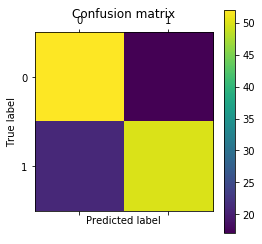

In [98]:
plt.matshow(confusion_matrix(test_labels, np.array(pr) > 0.5))
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Попробуем усреднить преобразованный сеткой датасет

In [99]:
window = 1000
step = 500
length = 150

In [76]:
def preprocess_avg(signal):
    count = int(float(len(signal) - window) / float(step))
    avg_signal = np.zeros((count, length))

    for j in xrange(count):
        slice_x = signal[j*step:j*step+window].reshape((-1, 1))
        slice_x = np.array(slice_x, dtype=np.float32)
        slice_x = preprocess_signal(slice_x)
        
        x_250 = resample(slice_x, 250).reshape((1, -1, 1))
        x_500 = resample(slice_x, 500).reshape((1, -1, 1))
        x_1000 = slice_x.reshape((1, -1, 1))
        
        avg_signal[j, :] += preprocess.predict([x_250, x_500, x_1000]).reshape(-1)
    
    return avg_signal.mean(axis=0)

In [108]:
test_avg_preprocess = []
for j in tqdm.tqdm_notebook(xrange(len(test_data))):
    person_signals = []
    for i in xrange(len(test_data[j])):
        person_signals.append(preprocess_avg(test_data[j][i]))
    test_avg_preprocess.append(person_signals)

In [109]:
def choose_random_signal(data, labels):
    i = random.randint(0, len(data) - 1)
    j = random.randint(0, len(data[i]) - 1)
    return data[i][j], labels[i]

In [110]:
cv_2 = StratifiedKFold(n_splits=5, shuffle=True, random_state=6)

accs = []
aucs = []
maxaccs = []

global_y  = []
global_pr = []

for tr, ts in cv_2.split(test_data, test_labels):

    train_data_2   = [test_avg_preprocess[t] for t in tr]
    train_labels_2 = [test_labels[t] for t in tr]
    test_data_2    = [test_avg_preprocess[t] for t in ts]
    test_labels_2  = [test_labels[t] for t in ts]
        
    X_train = np.empty((10000, 150))
    X_test  = np.empty((10000, 150))
    y_train = np.empty(10000)
    y_test  = np.empty(10000)
    for i in xrange(len(X_train)):
        X_train[i, :], y_train[i] = choose_random_signal(train_data_2, train_labels_2)
        X_test[i, :],  y_test[i]  = choose_random_signal(test_data_2,  test_labels_2)
    
    clf = RandomForestClassifier(n_estimators=1000, criterion='entropy', n_jobs=-1)
    clf.fit(X_train, y_train)
    pr = clf.predict_proba(X_test)[:, 1]
    
    global_y  += list(y_test)
    global_pr += list(pr)
    
    aucs.append(roc_auc_score(y_test, pr))
    accs.append(accuracy_score(y_test, pr > 0.5))
    maxaccs.append(max_accuracy_score(y_test, pr))

In [111]:
print 'mean auc:', np.mean(aucs)
print 'mean acc:', np.mean(accs)
print 'mean max acc:', np.mean(maxaccs)

mean auc: 0.688430570317
mean acc: 0.62434
mean max acc: 0.69116


А теперь прикинем, что было бы, если бы работали с коэффициентами Фурье с таких же коротких окон.

In [121]:
random.seed(777)

train_size = 10000
signal_tmp = np.zeros((train_size, window))
trainy = np.zeros(train_size)

for j in tqdm.tqdm_notebook(xrange(train_size)):
    i = random.randint(0, len(train_data) - 1)
    k = random.randint(0, len(train_data[i]) - 1)
    slice_start = random.randint(0, len(train_data[i][k]) - slice_len)
    signal_tmp[j, :] = train_data[i][k][slice_start:slice_start+slice_len]
    trainy[j] = train_labels[i]
    
trainX = np.abs(fft(signal_tmp))[:, :500]

In [122]:
random.seed(777)

test_size = 10000
signal_tmp = np.zeros((test_size, window))
testy = np.zeros(test_size)

for j in tqdm.tqdm_notebook(xrange(test_size)):
    i = random.randint(0, len(test_data) - 1)
    k = random.randint(0, len(test_data[i]) - 1)
    slice_start = random.randint(0, len(test_data[i][k]) - slice_len)
    signal_tmp[j, :] = test_data[i][k][slice_start:slice_start+slice_len]
    testy[j] = test_labels[i]
    
testX = np.abs(fft(signal_tmp))[:, :500]

In [123]:
clf = RandomForestClassifier(n_estimators=1000, criterion='entropy', n_jobs=-1)
clf.fit(trainX, trainy)
pr = clf.predict_proba(testX)[:, 1]

In [124]:
print 'auc:', roc_auc_score(testy, pr)
print 'acc:', max_accuracy_score(testy, pr)

auc: 0.711609467037
acc: 0.6618


Другое дело было, когда эти признки усреднялись для разных окон.

А теперь усредним предсказания по таким же окнам.

In [126]:
pr = []
for s in tqdm.tqdm_notebook(xrange(len(test_data))):    
    pr_person = 0
    for j in xrange(len(test_data[s])):
        sig = test_data[s][j]
        count_part_1 = sig.shape[0] / window
        count_part_2 = (sig.shape[0] - step) / window
        rsig = np.vstack((sig[:count_part_1*window].reshape((count_part_1, window)),
                          sig[step:step+count_part_2*window].reshape((count_part_2, window))))    
        pr_person += clf.predict_proba(np.abs(fft(rsig, axis=1))[:, :500])[:, 1].mean()
    pr.append(pr_person / float(len(test_data[s]))) 

In [128]:
print 'auc:', roc_auc_score(test_labels, pr)
print 'acc:', max_accuracy_score(test_labels, pr)

 auc: 0.75974688712
acc: 0.721428571429


#### t-SNE

In [71]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

Для каждого человека возьмём случайный слайс, сделаем преобразование и отобризим.

In [39]:
data = np.empty((len(signals), 150), dtype=float)
for i in xrange(len(signals)):
    j = random.randint(0, len(signals[i]) - 1)
    slice_start = random.randint(0, len(signals[i][j]) - slice_len - 1)
    old_slice = preprocess_signal(signals[i][j][slice_start:slice_start+slice_len])
    new_slice = preprocess.predict([resample(old_slice, 250).reshape((1, -1, 1)), 
                                    resample(old_slice, 500).reshape((1, -1, 1)), 
                                    old_slice.reshape((1, -1, 1))])
    data[i] = new_slice.ravel()

In [73]:
tsne = TSNE(n_components=2, perplexity=100)
pca  = PCA(n_components=2)

In [74]:
tsne_data = tsne.fit_transform(data)
pca_data  = pca.fit_transform(data)

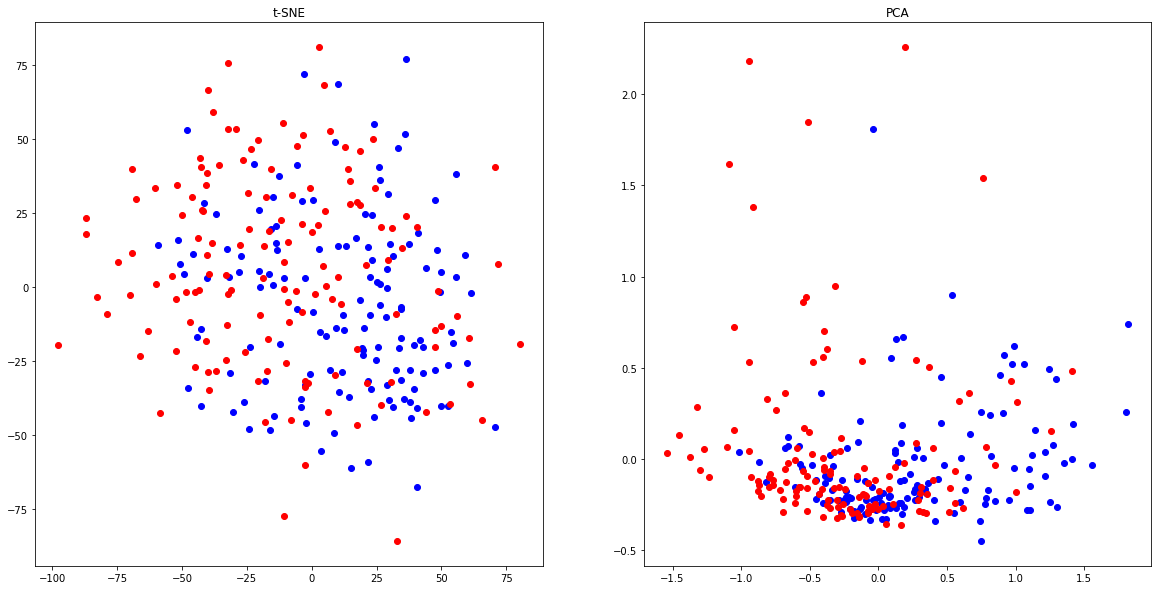

In [75]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.title('t-SNE')
plt.plot(tsne_data[labels == 0, 0], tsne_data[labels == 0, 1], 'bo')
plt.plot(tsne_data[labels == 1, 0], tsne_data[labels == 1, 1], 'ro')

plt.subplot(1, 2, 2)
plt.title('PCA')
plt.plot(pca_data[labels == 0, 0], pca_data[labels == 0, 1], 'bo')
plt.plot(pca_data[labels == 1, 0], pca_data[labels == 1, 1], 'ro')

plt.show()

Получается не очень-то хорошо, хотя некую концентрацию разных классов в разных сторонах увидеть можно. Попробуем брать усреднённое состояние для каждого человека.

In [80]:
window = 1000
step = 500
length = 150

In [82]:
data = np.zeros((len(signals), 150), dtype=float)
for i in tqdm.tqdm_notebook(xrange(len(signals))):
    for j in xrange(len(signals[i])):
        data[i] += preprocess_avg(signals[i][j])
    data[i] = data[i] / len(signals[i])

In [92]:
tsne = TSNE(n_components=2, perplexity=100)
pca  = PCA(n_components=2)

In [93]:
tsne_data = tsne.fit_transform(data)
pca_data  = pca.fit_transform(data)

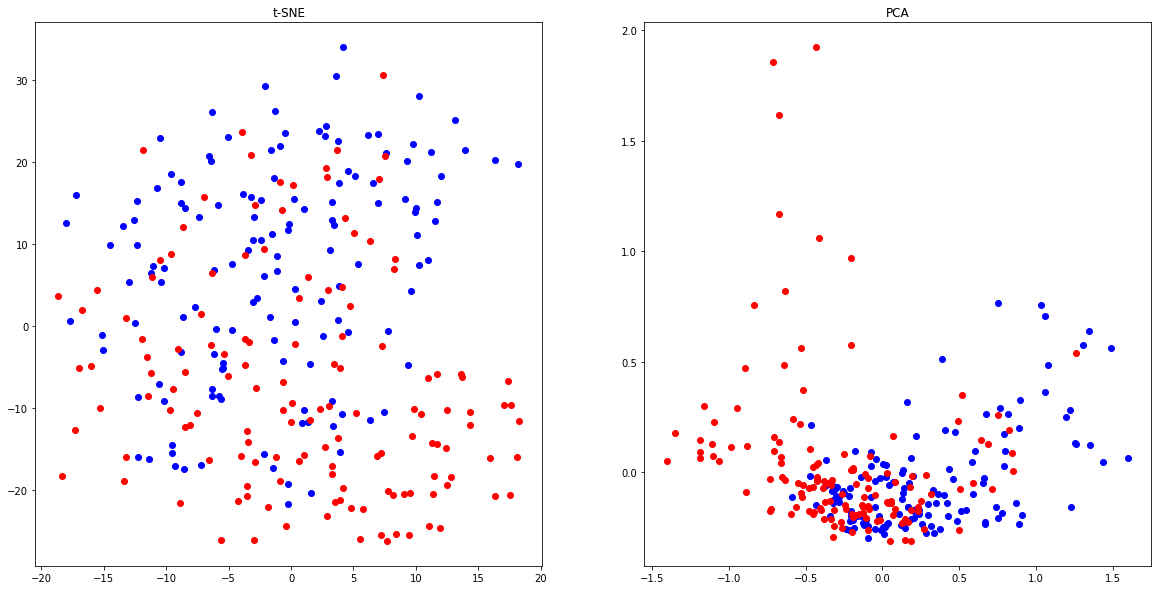

In [94]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.title('t-SNE')
plt.plot(tsne_data[labels == 0, 0], tsne_data[labels == 0, 1], 'bo')
plt.plot(tsne_data[labels == 1, 0], tsne_data[labels == 1, 1], 'ro')

plt.subplot(1, 2, 2)
plt.title('PCA')
plt.plot(pca_data[labels == 0, 0], pca_data[labels == 0, 1], 'bo')
plt.plot(pca_data[labels == 1, 0], pca_data[labels == 1, 1], 'ro')

plt.show()

Получили схожую ситуацию, но визуально с чуть большей сконцентрированностью. Попробуем анализировать различия внутренних состояней отдельных людей.

In [96]:
size = [len(x) for x in signals]

In [108]:
[(i, labels[i], size[i]) for i in np.argsort(size)[-15:]]

[(5, 0, 13),
 (70, 1, 15),
 (134, 0, 17),
 (3, 0, 17),
 (0, 0, 19),
 (247, 0, 23),
 (30, 0, 23),
 (54, 0, 32),
 (1, 0, 67),
 (99, 0, 81),
 (2, 0, 99),
 (27, 0, 100),
 (189, 1, 100),
 (32, 0, 100),
 (4, 0, 100)]

In [109]:
data = np.empty((15 * 4, 150), dtype=float)
inds = [70, 189, 27, 4]

for i, ind in enumerate(inds):
    for j in xrange(15):
        data[i*15+j] = preprocess_avg(signals[ind][j]) 

In [146]:
tsne = TSNE(n_components=2, perplexity=10)
pca  = PCA(n_components=2)

In [147]:
tsne_data = tsne.fit_transform(data)
pca_data  = pca.fit_transform(data)

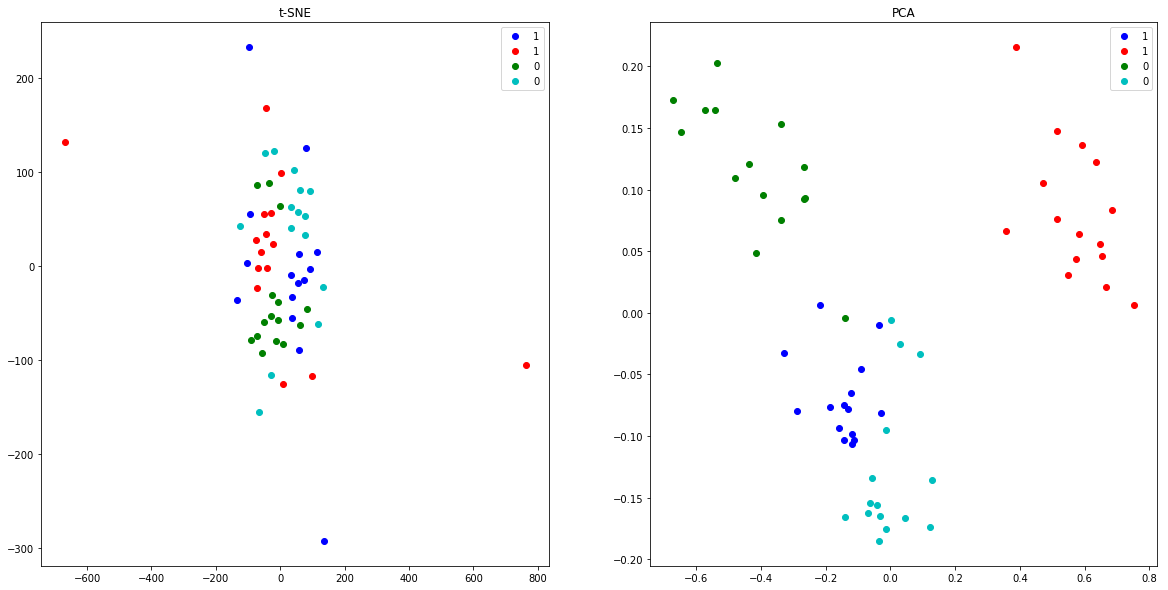

In [148]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.title('t-SNE')
plt.plot(tsne_data[0:15, 0], tsne_data[0:15, 1], 'bo', label='1')
plt.plot(tsne_data[15:30, 0], tsne_data[15:30, 1], 'ro', label='1')
plt.plot(tsne_data[30:45, 0], tsne_data[30:45, 1], 'go', label='0')
plt.plot(tsne_data[45:60, 0], tsne_data[45:60, 1], 'co', label='0')
plt.legend(loc=0)

plt.subplot(1, 2, 2)
plt.title('PCA')
plt.plot(pca_data[0:15, 0], pca_data[0:15, 1], 'bo', label='1')
plt.plot(pca_data[15:30, 0], pca_data[15:30, 1], 'ro', label='1')
plt.plot(pca_data[30:45, 0], pca_data[30:45, 1], 'go', label='0')
plt.plot(pca_data[45:60, 0], pca_data[45:60, 1], 'co', label='0')
plt.legend(loc=0)

plt.show()

Можно заметить, что внутренние состояние разных людей различаются, но нельзя сказать, что их классы разделяются.